In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import stats

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
df = pd.read_csv('iris.csv')
df.drop('Id', axis=1, inplace=True)

In [5]:
train, test = train_test_split(df)
train.head()

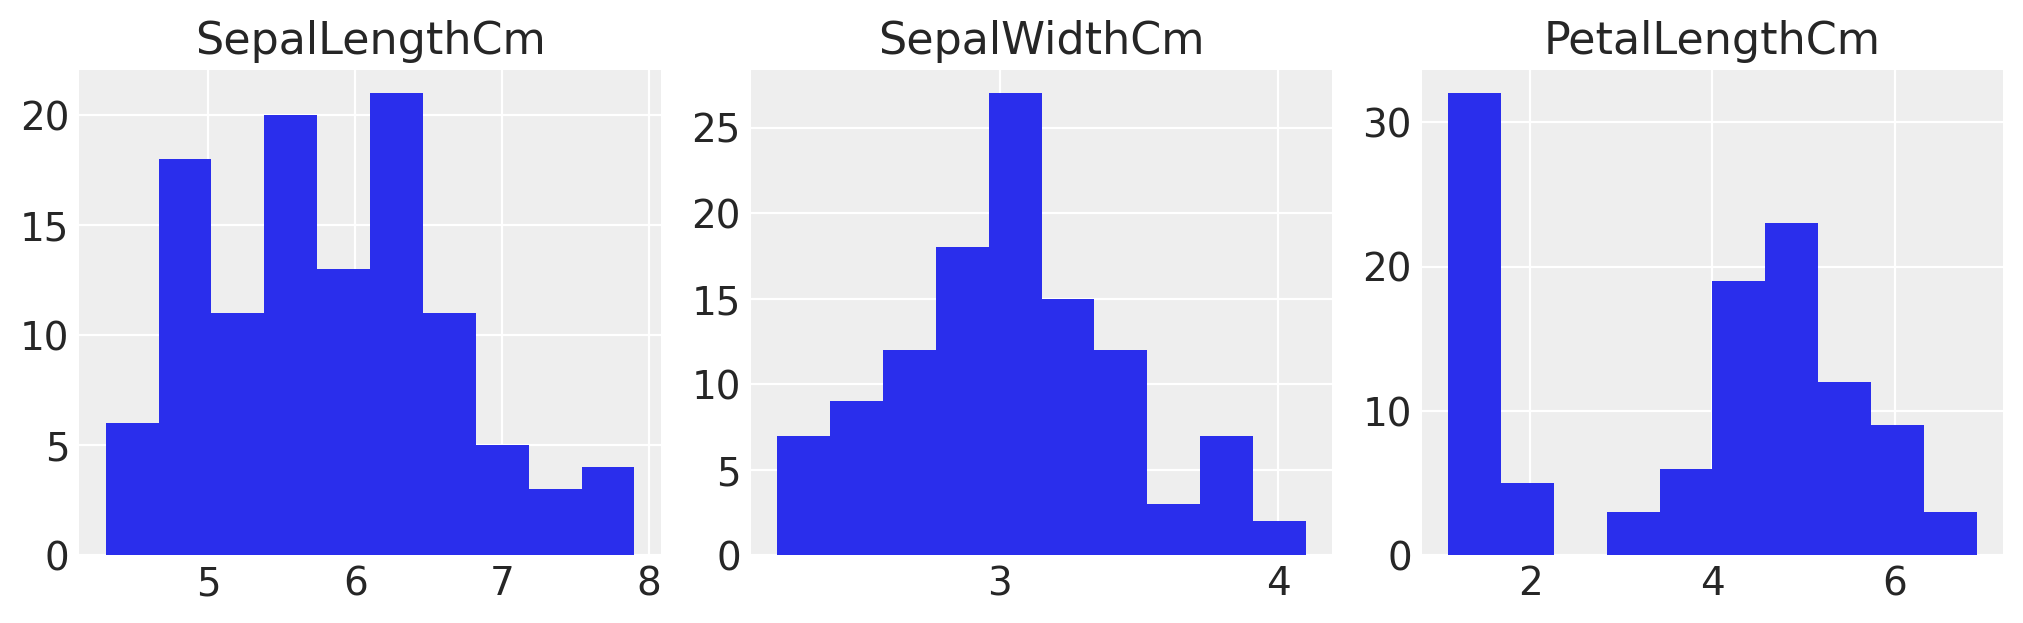

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()

ax[0].hist(train['SepalLengthCm'])
ax[1].hist(train['SepalWidthCm'])
ax[2].hist(train['PetalLengthCm'])

ax[0].set_title('SepalLengthCm')
ax[1].set_title('SepalWidthCm')
ax[2].set_title('PetalLengthCm')

plt.show()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


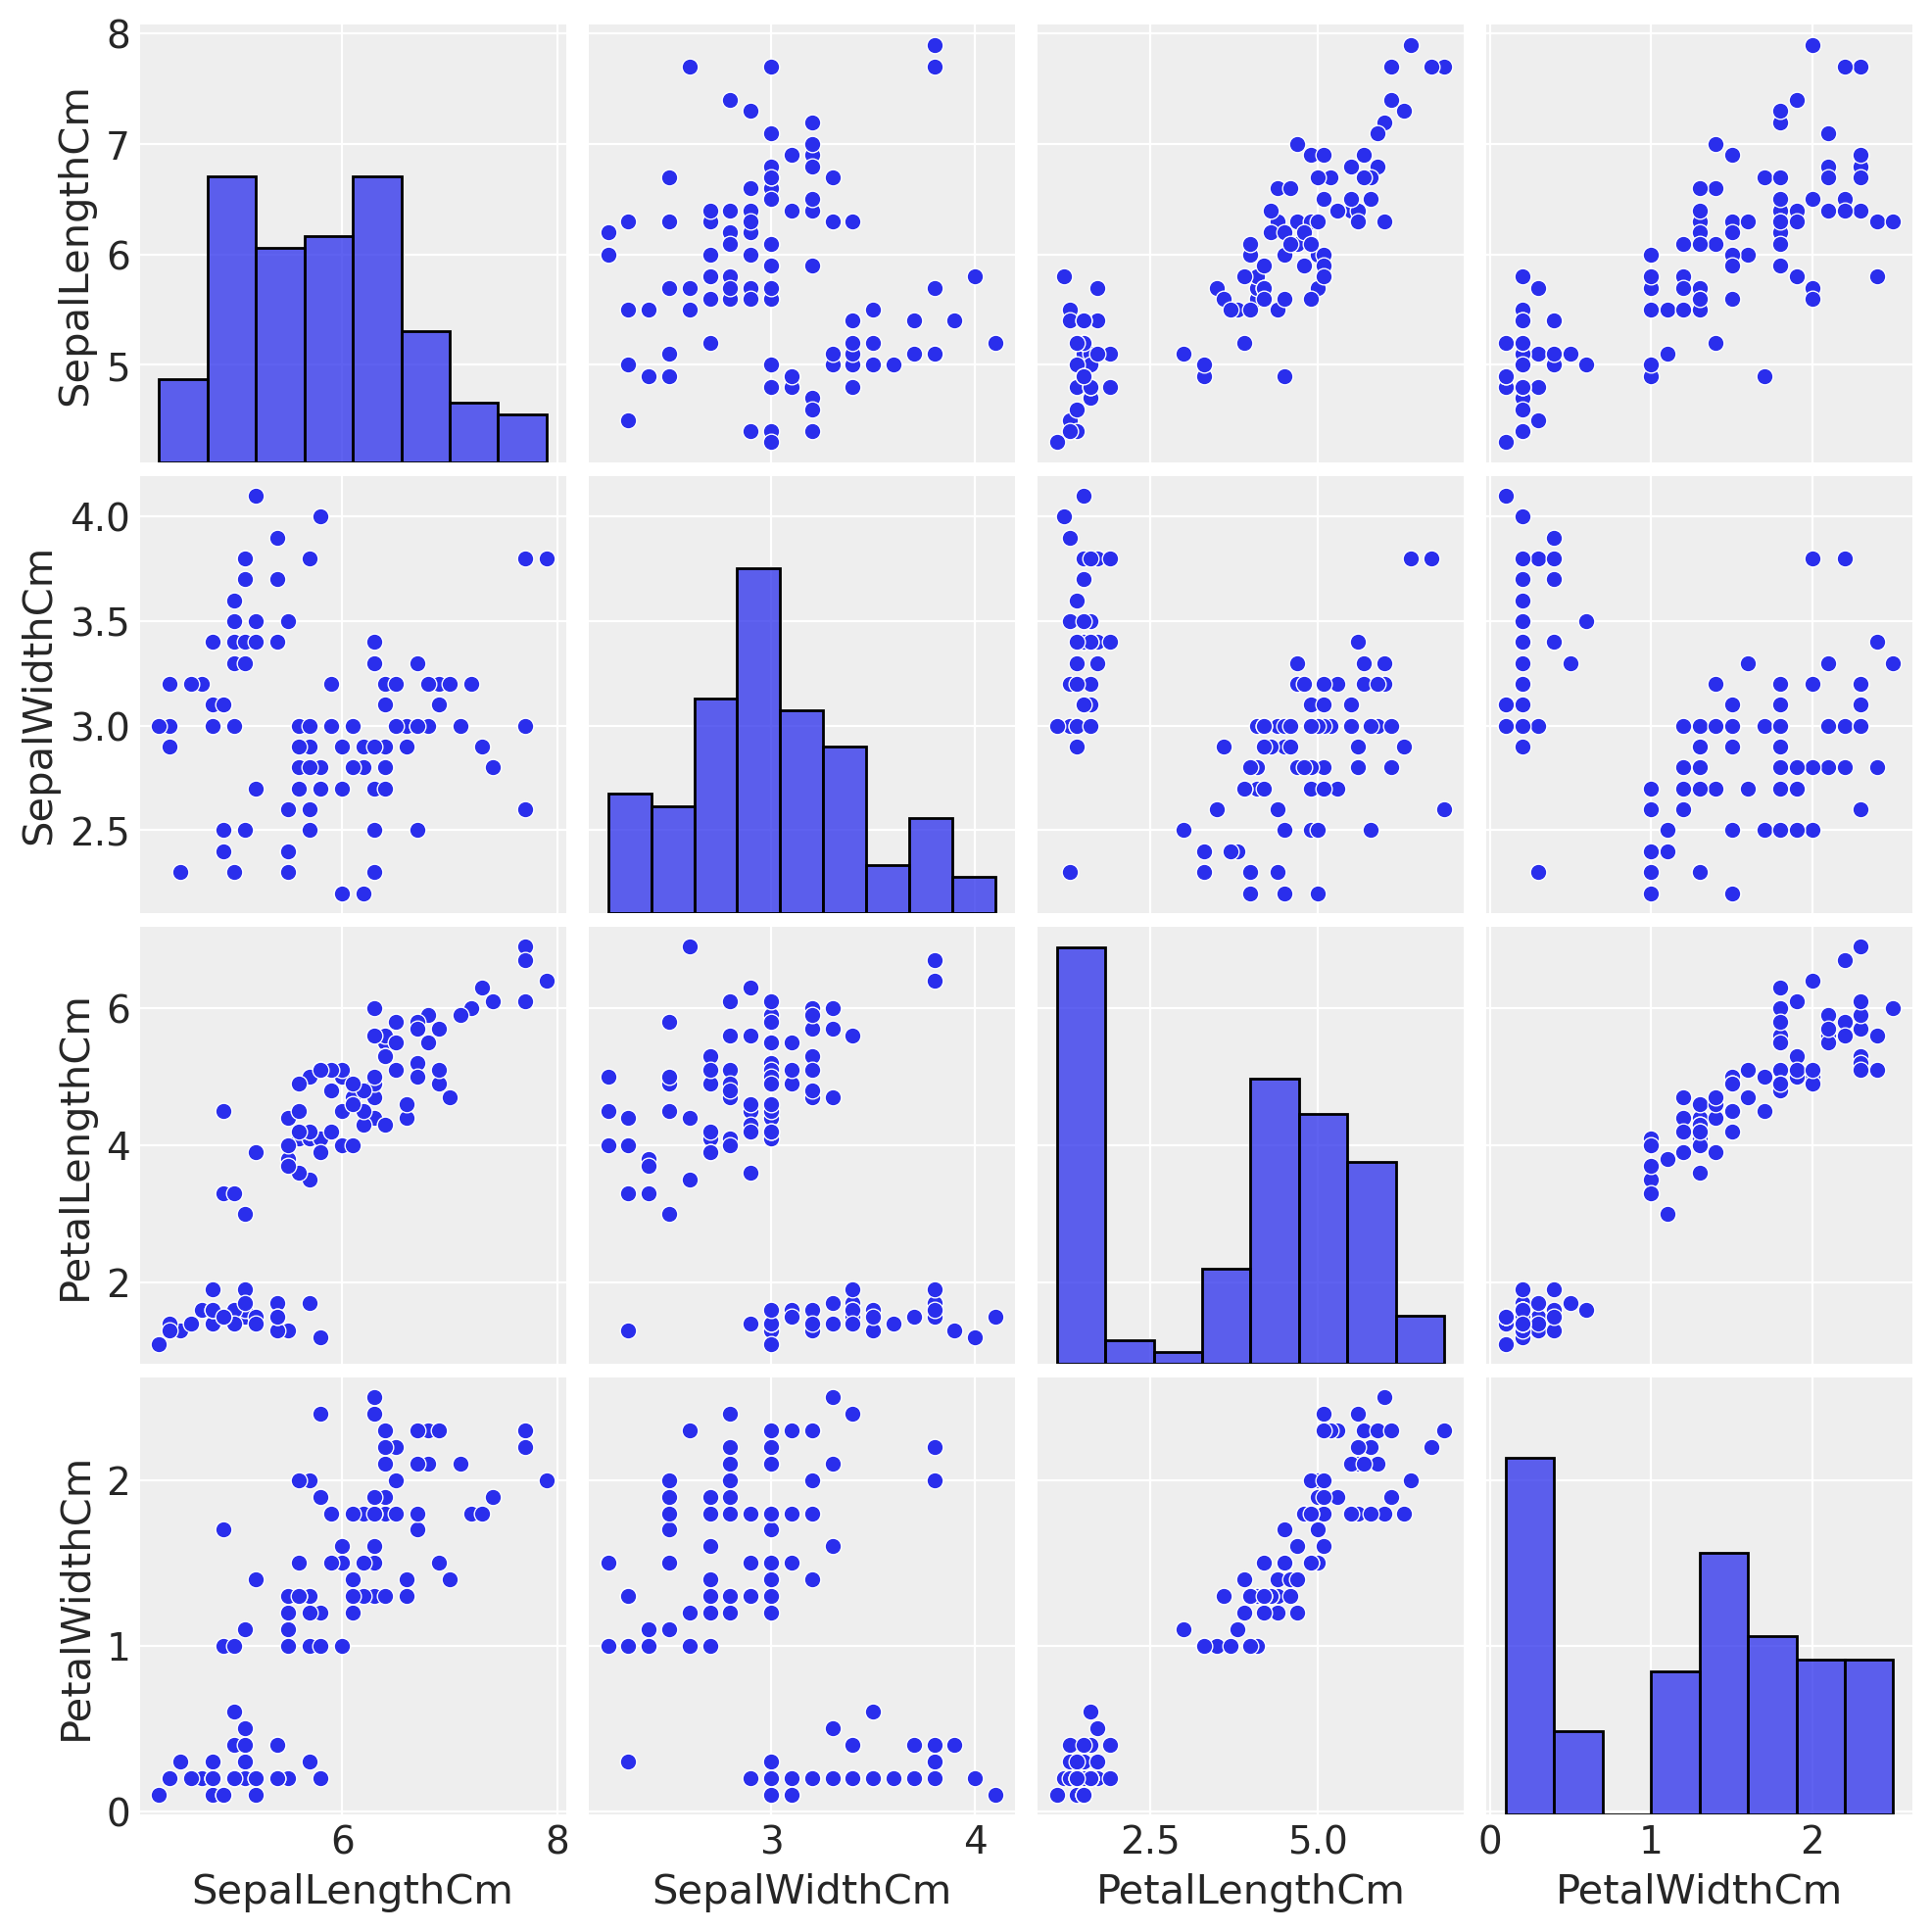

In [10]:
sns.pairplot(train)

In [11]:
import sys

try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install --upgrade bambi
    import bambi as bmb

In [18]:
# Build 3 one-versus-all Bayesian Logistic Regression model
model_setosa = bmb.Model(
    "Species['Iris-setosa'] ~ SepalLengthCm + SepalWidthCm + PetalLengthCm + PetalWidthCm", 
    train, 
    family='bernoulli'
)
model_versicolor = bmb.Model(
    "Species['Iris-versicolor'] ~ SepalLengthCm + SepalWidthCm + PetalLengthCm + PetalWidthCm", 
    train, 
    family='bernoulli'
)
model_virginica = bmb.Model(
    "Species['Iris-virginica'] ~ SepalLengthCm + SepalWidthCm + PetalLengthCm + PetalWidthCm", 
    train, 
    family='bernoulli'
)

idata_setosa = model_setosa.fit(draws=5000)
idata_versicolor = model_versicolor.fit(draws=5000)
idata_virginica = model_virginica.fit(draws=5000)

Modeling the probability that Species==Iris-setosa
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.
Modeling the probability that Species==Iris-versicolor
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 33 seconds.
Modeling the probability that Species==Iris-virginica
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.


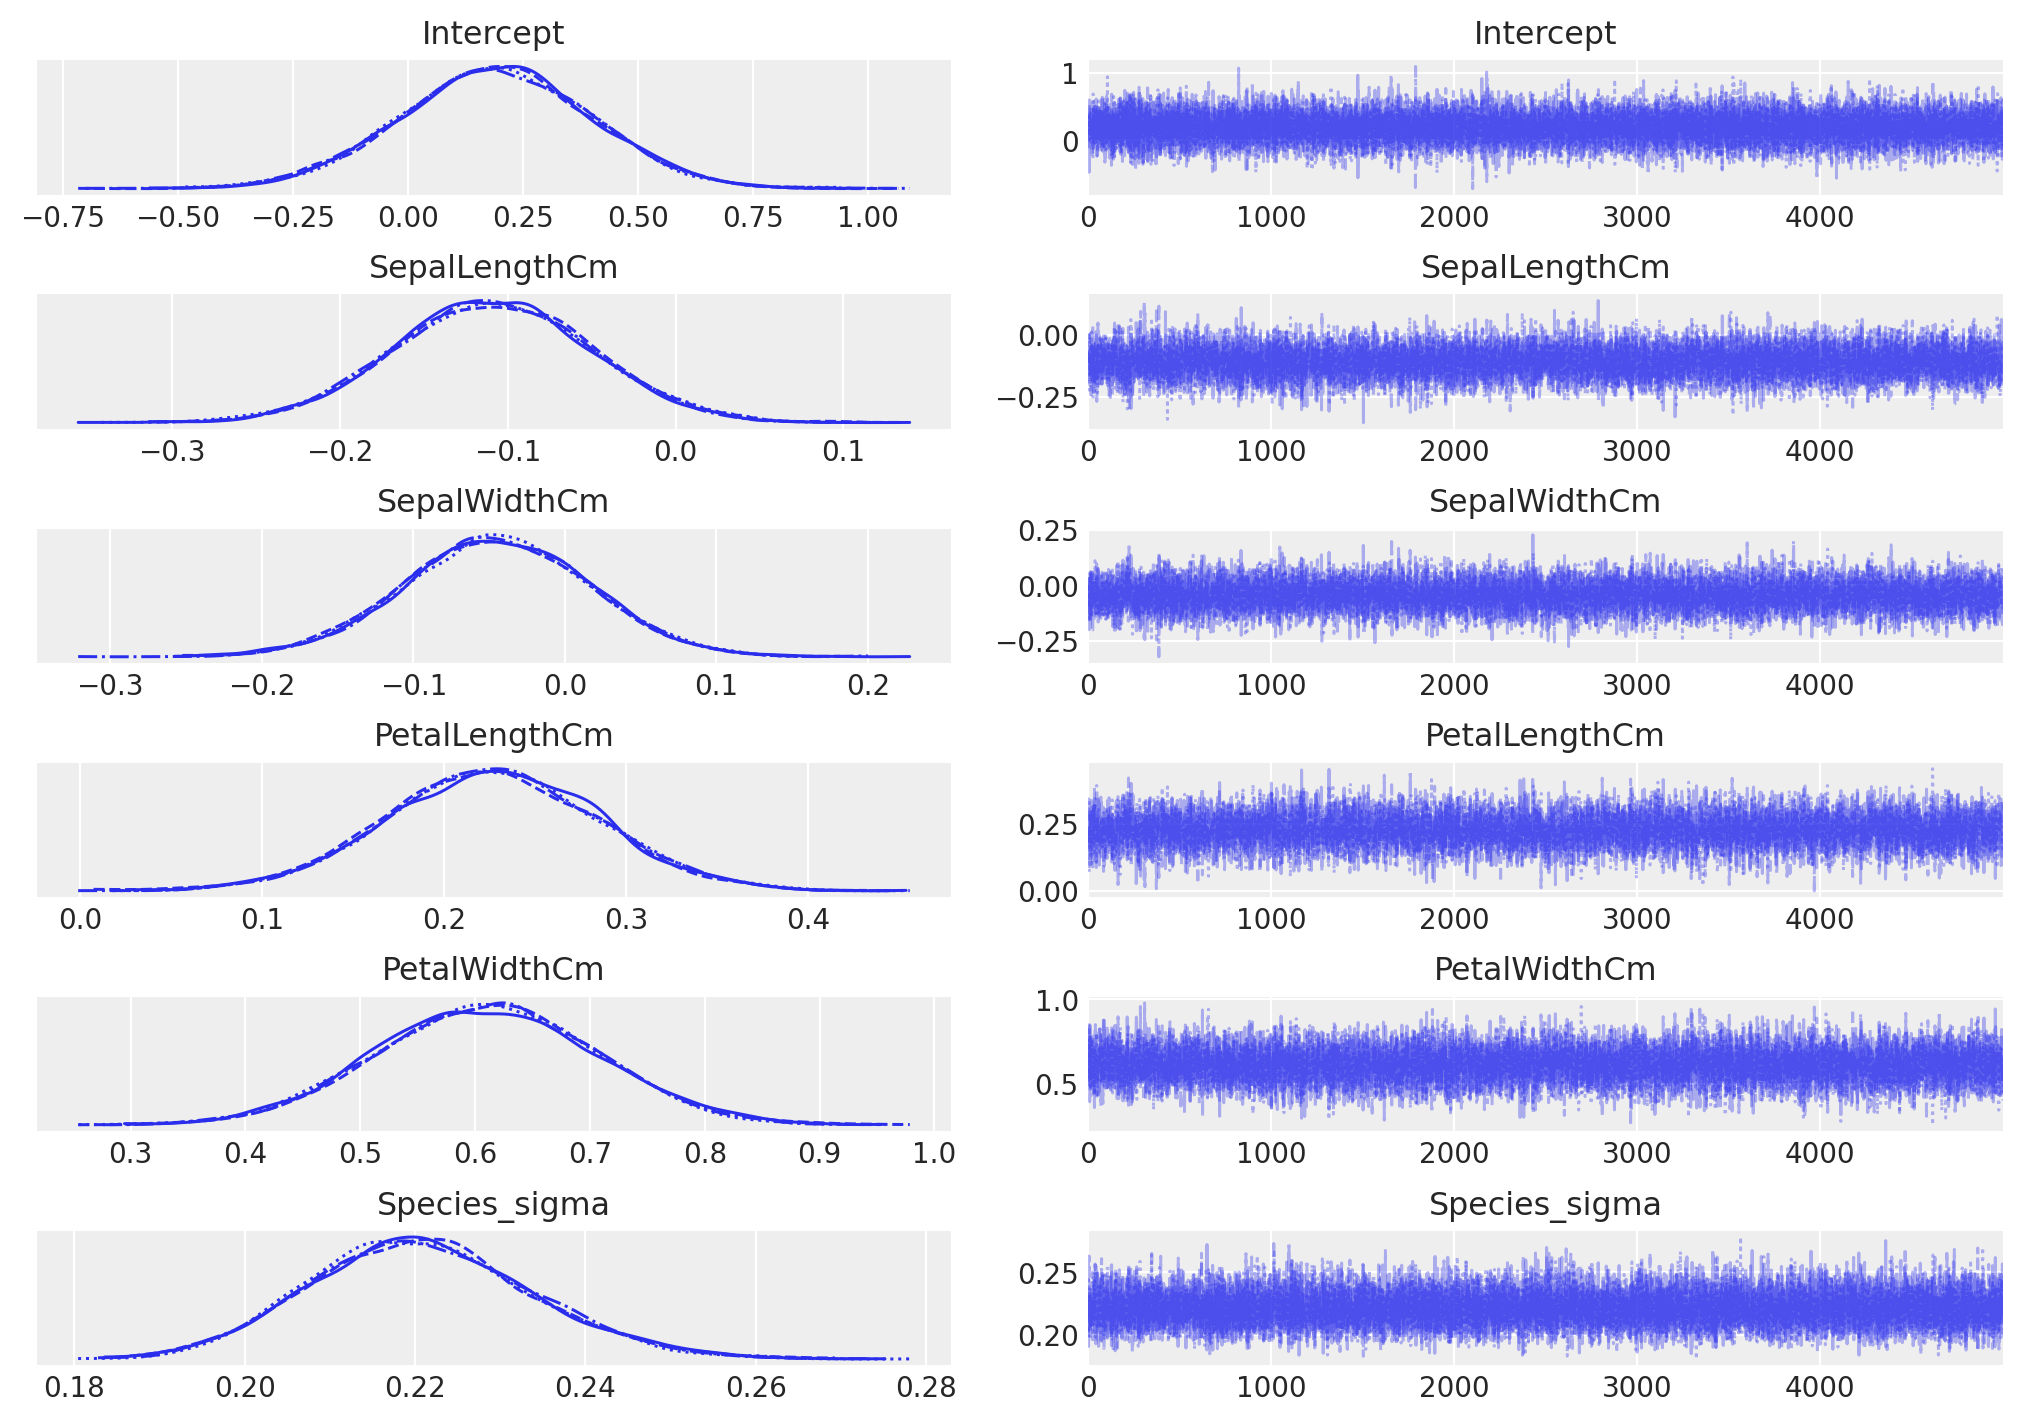

In [32]:
az.plot_trace(idata_setosa, figsize=(10, 7));

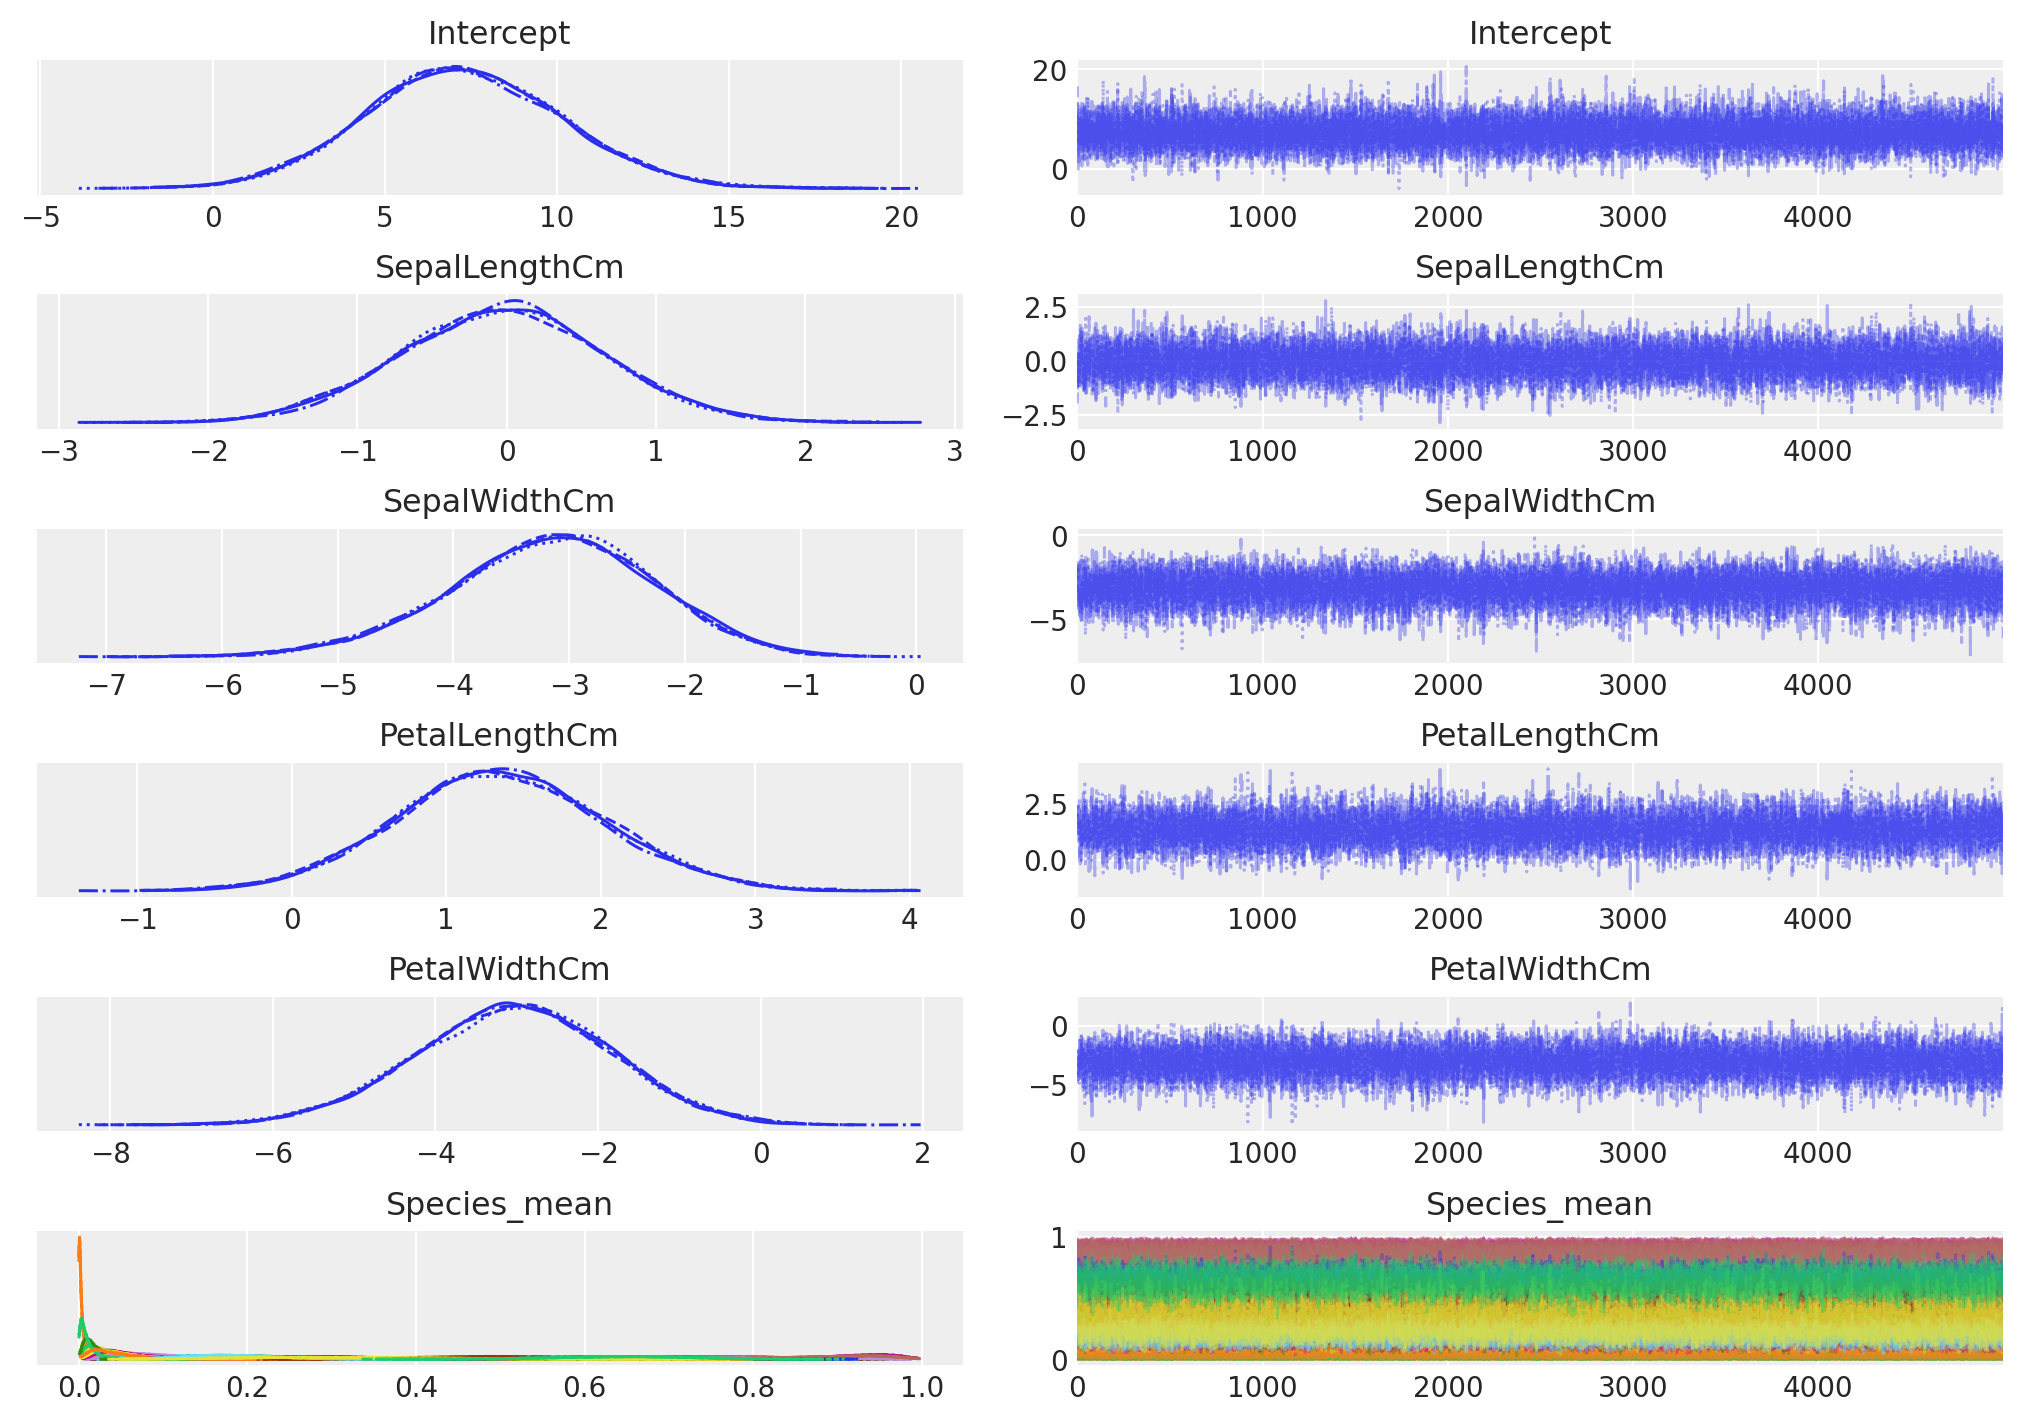

In [89]:
az.plot_trace(idata_versicolor, figsize=(10, 7));

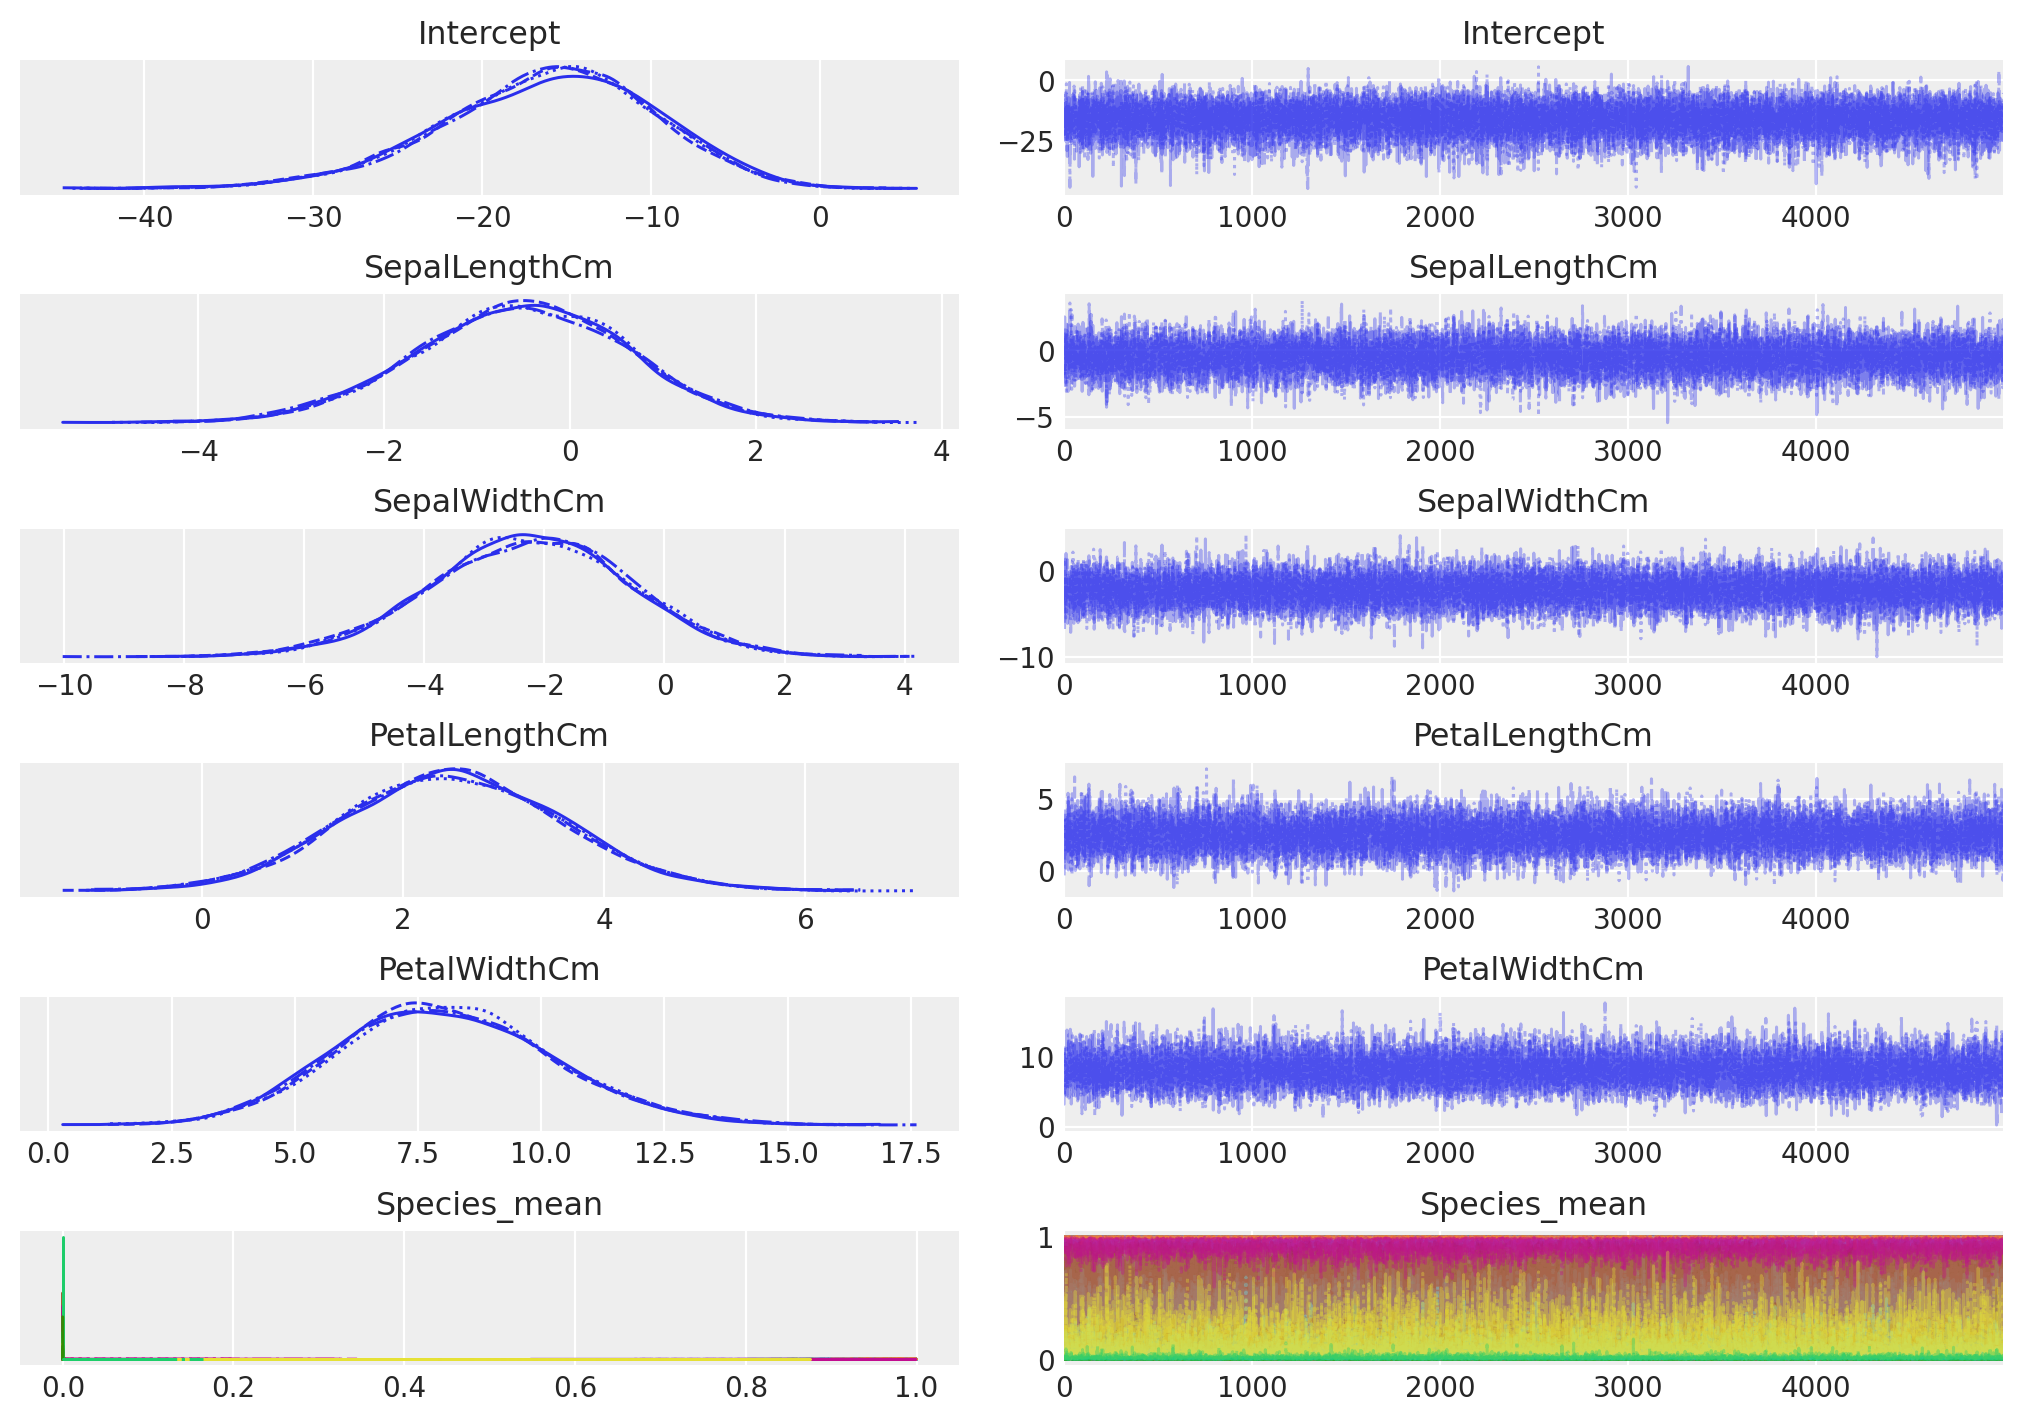

In [90]:
az.plot_trace(idata_virginica, figsize=(10, 7));

# Out Of Sample Predictions

In [19]:
model_setosa.predict(idata_setosa, data=test)
model_versicolor.predict(idata_versicolor, data=test)
model_virginica.predict(idata_virginica, data=test)

In [38]:
# Select a sample of posterior values for the mean probability of voting for Clinton
setosa_posterior = az.extract_dataset(idata_setosa, num_samples=2000)["Species_mean"]
versicolor_posterior = az.extract_dataset(idata_versicolor, num_samples=2000)["Species_mean"]
virginica_posterior = az.extract_dataset(idata_virginica, num_samples=2000)["Species_mean"]

In [39]:
setosa_proba = (setosa_posterior.values >= .5).mean(axis=1)
versicolor_proba = (versicolor_posterior.values >= .5).mean(axis=1)
virginica_proba = (virginica_posterior.values >= .5).mean(axis=1)

In [71]:
y_proba = np.vstack([setosa_proba, versicolor_proba, virginica_proba]).T
y_pred = y_proba.argmax(axis=1)
pred_to_cat = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}
y_pred = [pred_to_cat[y] for y in y_pred]
print(classification_report(test['Species'], y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       0.79      0.85      0.81        13
 Iris-virginica       0.82      0.75      0.78        12

       accuracy                           0.87        38
      macro avg       0.87      0.87      0.87        38
   weighted avg       0.87      0.87      0.87        38

